In [1]:
import os
import csv
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from scipy import stats
from pathlib import Path
from datetime import datetime
from tqdm.notebook import tqdm
from collections import namedtuple
from matplotlib import pyplot as plt
from typing import Any, List, Optional, Union, Tuple

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision.datasets.vision import VisionDataset

from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)

from pymilvus import (
    connections, 
    FieldSchema, 
    CollectionSchema, 
    DataType, 
    Collection, 
    drop_collection, 
    utility
)

import warnings
warnings.filterwarnings(action="ignore")

# Dataset

In [2]:
class CelebA(VisionDataset):

    base_folder = "celeba"

    def __init__(
        self, 
        root: str = "./",
        split: str = "train"
    ) -> None:
        super().__init__(root)
        if split == "train":
            self.identity = pd.read_csv(self.base_folder + '/data_train.csv')
        else:
            self.identity = pd.read_csv(self.base_folder + '/data_test.csv')
        self.filename = self.identity.img_name

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path_to_file = os.path.join(self.root, self.base_folder, "dataset", self.filename[index])
                
        image = np.array(Image.open(path_to_file))
        target = self.identity["classes"][index]
        
        return image, target

    def __len__(self) -> int:
        return len(self.identity.img_name)

In [3]:
data = pd.read_csv('celeba/identity_CelebA.txt', sep=" ", header=None)
data.columns = ["img_name", "classes"]
classes = [4887, 7548, 2937, 9040, 4627, 9672]
data = data.loc[data.classes.isin(classes)].reset_index(drop=True)

In [4]:
data.loc[data.classes == 4887, "name"] = "Jorma Taccone"
data.loc[data.classes == 7548, "name"] = "Patrick J. Adams"
data.loc[data.classes == 2937, "name"] = "Emilia Fox"
data.loc[data.classes == 9040, "name"] = "Stephen Colletti"
data.loc[data.classes == 4627, "name"] = "Jimmy Carr"
data.loc[data.classes == 9672, "name"] = "Angela Merkel"

data.classes = data.classes.map({4887:0, 7548:1, 2937:2, 9040:3, 4627:4, 9672:5})

In [5]:
img_to_test = ["000002.jpg", "000007.jpg", "000069.jpg", "000116.jpg", "000417.jpg", "183012.jpg"]

In [6]:
data_train = data.loc[~data.img_name.isin(img_to_test)]
data_test = data.loc[data.img_name.isin(img_to_test)]

In [7]:
for img_file in img_to_test:
    img_to_save = Image.open("celeba/dataset/" + img_file)
    img_to_save.save(img_file)

In [8]:
data_train.to_csv("./celeba/data_train.csv")
data_test.to_csv("./celeba/data_test.csv")

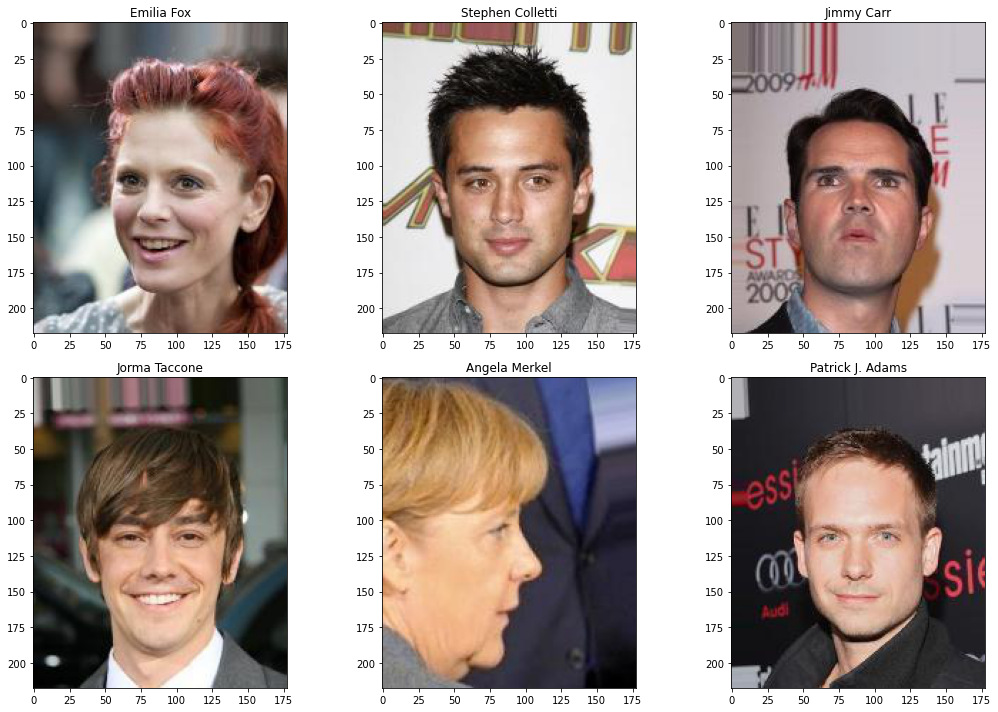

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, (index, row) in enumerate(data_test.iterrows()):
    img_to_plot = np.array(Image.open("celeba/dataset/" + row.img_name))
    axes[i].imshow(img_to_plot)
    axes[i].set_title(row["name"])
plt.tight_layout()
plt.show()

In [10]:
dataset = CelebA()
dataset_test = CelebA(split="test")

In [11]:
mapper = {element[1]: element[0] for element in data_train.loc[:, ["classes", "name"]].sort_values("classes").drop_duplicates().values}

In [13]:
BATCH_SIZE = 32

main_dl = DataLoader(
    dataset,
    BATCH_SIZE,
    pin_memory=False,
    num_workers=4,
    drop_last=False,
    shuffle=False
)

In [14]:
test_dl = DataLoader(
    dataset_test,
    BATCH_SIZE,
    pin_memory=False,
    num_workers=4,
    drop_last=False,
    shuffle=False
)

# Model

In [15]:
def get_embeddings(mtcnn, resnet, dataloader):
    aligned = []
    classes = []
    for x, y in dataloader:
        x_aligned, prob = mtcnn(x, return_prob=True)
        aligned.extend(x_aligned)
        classes.extend(y.numpy())
    classes = np.array(classes)
    aligned = torch.stack(aligned).to(device)
    embeddings = resnet(aligned).detach().cpu().numpy()
    
    return embeddings, classes

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [17]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [18]:
embeddings, classes = get_embeddings(mtcnn, resnet, dataloader=main_dl)

In [19]:
embeddings_test, classes_test = get_embeddings(mtcnn, resnet, dataloader=test_dl)

In [21]:
normalizer = Normalizer().fit(embeddings)
embeddings_norm = normalizer.transform(embeddings)
embeddings_test_norm = normalizer.transform(embeddings_test)

In [22]:
with open('normalizer.pickle', 'wb') as handle:
    pickle.dump(normalizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Milvus

In [23]:
# connection.close()
connection = connections.connect(host='34.133.183.222', port='19530')

In [24]:
has = utility.has_collection("embeddings_faces")
print(f"Does collection hello_milvus exist in Milvus: {has}")

Does collection hello_milvus exist in Milvus: True


In [25]:
drop_collection(collection_name='embeddings_faces')

In [26]:
collection_name = 'embeddings_faces'

schema = CollectionSchema([
            FieldSchema("embedding_id", DataType.INT64, is_primary=True),
            FieldSchema("label_id", DataType.INT64),
            FieldSchema("embeddings", dtype=DataType.FLOAT_VECTOR, dim=512)
        ])

collection = Collection(name=collection_name, schema=schema, using='default', shards_num=2)

In [27]:
collection = Collection(name="embeddings_faces")

In [28]:
data = [[i for i in range(len(classes))], 
        classes.tolist(), 
        embeddings_norm.tolist()
       ]

with open('embeddings_faces.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
len(data[2])

165

In [29]:
collection.insert(data)

index_params = {
        "metric_type":"L2",
        "index_type":"IVF_FLAT",
        "params":{"nlist":1024}
    }
collection.create_index("embeddings", index_params=index_params)
collection.load()

In [30]:
with open('mapper_faces.pickle', 'wb') as handle:
    pickle.dump(mapper, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [31]:
mapper

{'Jorma Taccone': 0,
 'Patrick J. Adams': 1,
 'Emilia Fox': 2,
 'Stephen Colletti': 3,
 'Jimmy Carr': 4,
 'Angela Merkel': 5}

# Quality

In [32]:
def remap_it(idx_class, mapper, decode=True):
    if decode:
        result = list(mapper.keys())[list(mapper.values()).index(idx_class)]
    else:
        result = list(mapper.values())[list(mapper.keys()).index(idx_class)]
    return result

def milvus_search(
    embeddings: List[List[float]],
    host: str = "34.133.183.222",
    port: str = "19530",
    collection_name: str = "embeddings_faces",
):
    connection = connections.connect(host=host, port=port)

    ids_range = list(
        range(connection.get_collection_stats(collection_name)["row_count"])
    )

    maping_df = connection.query(
        collection_name=collection_name,
        expr=f"embedding_id in {ids_range}",
        output_fields=["embedding_id", "label_id"],
    )

    maping_df = (
        pd.DataFrame.from_dict(maping_df)
        .sort_values(by="embedding_id")
        .reset_index(drop=True)
    )

    search_params = {"metric_type": "L2", "params": {"nprobe": 1024}}

    result_ids = connection.search(
        collection_name=collection_name,
        data=embeddings,
        anns_field="embeddings",
        param=search_params,
        limit=3,
        expression=None,
    )

    result_ids = [element.ids for element in result_ids]

    concat_df = pd.DataFrame(index=range(len(np.array(result_ids).T[0])))
    for i in range(len(np.array(result_ids).T)):
        df = (
            maping_df.iloc[np.array(result_ids).T[i]].reset_index().loc[:, ["label_id"]]
        )
        concat_df = pd.concat([concat_df, df], axis=1)
    concat_df["result"] = concat_df.mode(axis=1)[0].values.astype(int)
    predictions_label_id = concat_df.loc[:, "result"].values.astype(int)

    with open("mapper_faces.pickle", "rb") as handle:
        mapper_dict = pickle.load(handle)

    predictions = [
        remap_it(class_id, mapper_dict, decode=True)
        for class_id in predictions_label_id
    ]
    return predictions

In [33]:
results = milvus_search(embeddings_test_norm)

In [34]:
results

['Emilia Fox',
 'Stephen Colletti',
 'Jimmy Carr',
 'Jorma Taccone',
 'Angela Merkel',
 'Patrick J. Adams']

In [ ]:
def quality_(predictions, labels_val, classes_train):
    print(f'accuracy = {accuracy_score(labels_val, np.argmax(predictions, 1))*100:0.04}%')

    print('precision_score = ', np.round(
        precision_score(labels_val, 
                        np.argmax(predictions, 1),
                        average='weighted', 
                        labels=np.unique(np.argmax(predictions, 1))
                       )*100, 2), "%")

    print('recall_score = ', np.round(
        recall_score(labels_val, 
                     np.argmax(predictions, 1), 
                     average='weighted', 
                     labels=np.unique(np.argmax(predictions, 1))
                    )*100, 
        2), "%")

    print('f1_score', np.round(
        f1_score(labels_val, 
                 np.argmax(predictions, 1), 
                 average='weighted', 
                 labels=np.unique(np.argmax(predictions, 1))
                )*100, 2), "%"
    )
    
    average_precision = AveragePrecision(num_classes=len(classes_train), average=None)
    ap_results = average_precision(torch.tensor(predictions), torch.tensor(labels_val))

    result_ap = pd.DataFrame(data = list(zip(classes_train, [element.item() for element in ap_results])),
                             columns = ["category", "ap_result"])
    
    print(result_ap.mean())
    return result_ap